# Algorithmic Trading Strategy Challenge

Name: Kyle Savino

In this challenge, your task is to design an algorithmic trading strategy using the stocks in the provided portfolio.
    
You may use yfinance to source data for the stocks within the period defined in the dummy_data.xlsx file.

You are not allowed to use a simple "buy and hold" strategy. Be creative and implement a more complex strategy that will maximize profit and minimize risk.

Your solution can be based on machine learning, technical analysis, or any other approach you find suitable.

Be creative and demonstrate your coding ability in this challenge.

In addition to implementing your strategy during this time period, you will also need to graph the profit/loss and liquidity ratio of the strategy over time.

Feel free to add code blocks and markdown blocks as needed, however, ensure specified logic is contained within their respective headers in the notebook.


In [2]:
# Name: Kyle Savino
'''General note: I had to reformat my code a little bit to get it to work as a .ipynb file, so I apologize if it looks messy anywhere.'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf



ModuleNotFoundError: No module named 'pandas'

In [ ]:

'''This list holds every day from 2023-7-1 until the end date, 2023-9-30. I use this list for the simulation of my algorithm.'''
dateList = [f"2023-07-{day:02}" for day in range(1, 32)] + [f"2023-08-{day:02}" for day in range(1, 32)] + [f"2023-09-{day:02}" for day in range(1, 31)]

class Stock:
    def __init__(self, ticker):
        self.quantity = 0
        self.ticker = ticker
        self.price = [0] * len(dateList)
        i = -1
        self.data = yf.download(ticker, start = dateList[0], end = dateList[91])
        # Downloading is done here so you only have to do it once
        self.mean = 0
        self.marketPrices = []
        for day in dateList:
            '''Initializes a self.price list for the stock object which holds its closing price for every day in the time period.
            If the market is closed on a given day, the stockPrice for that day is 0'''
            i +=1
            try:
                stockPrice = self.data.loc[day]["Close"]
            except (IndexError, ValueError, KeyError):
                continue
            self.price[i] = stockPrice
            if stockPrice != 0:
                self.marketPrices.append(stockPrice)

    def getValue(self, day):
        return self.quantity * self.price[day]

    def rateOfChange(self, startingDay, period):
        '''Returns the signed rate of change for the price of the stock over a given time period'''
        delta = 0
        daysReached = 0
        while period > 0 and startingDay > 0:
            while self.price[startingDay] == 0:
                startingDay -= 1
                if startingDay <= 0:
                    return delta/daysReached
            nextNonZeroDay = startingDay - 1
            if nextNonZeroDay < 0:
                return delta/daysReached
            while self.price[nextNonZeroDay] == 0:
                nextNonZeroDay -= 1
                if nextNonZeroDay < 0:
                    return delta/daysReached
            delta += self.price[startingDay] - self.price[nextNonZeroDay]
            daysReached += 1
            period -=1
            startingDay -= 1
        return delta/daysReached

    def findLastMarketDay(self, i):
        '''Returns the most recent day at an index which was the market was open'''
        while self.price[i] == 0:
            i -= 1
        return i

    def absoluteRateOfChange(self, startingDay, period):
        '''Returns the absolute value of the rate of change, used to measure volatility
        eg: a high number means that the price of this stock is jumping around a lot, but direction is unknown'''
        delta = 0
        daysReached = 0
        while period > 0 and startingDay > 0:
            while self.price[startingDay] == 0:
                if startingDay <= 0:
                    return delta
                startingDay -= 1
            nextNonZeroDay = startingDay - 1
            if nextNonZeroDay < 0:
                return delta
            while self.price[nextNonZeroDay] == 0:
                nextNonZeroDay -= 1
                if nextNonZeroDay < 0:
                    return delta
            if self.price[startingDay] - self.price[nextNonZeroDay] < 0:
                delta += self.price[nextNonZeroDay] - self.price[startingDay]
                daysReached += 1
                period -=1
                startingDay -= 1
            else:
                delta += self.price[startingDay] - self.price[nextNonZeroDay]
                daysReached += 1
                period -= 1
                startingDay -= 1
        return delta/daysReached



## Strategy Implementation

In [ ]:

'''These stocks are from the dummy portfolio, I tried to pick a mix of stocks with ranging volatility and performance.
This way my algorithm would be tested in a wide variety of scenarios'''

'''Synposis: 
My algorithm primarily employs a mean reversion strategy. At each day, starting at 3 days after the beginning of the time period (07-01-2023 to 09-30-2023),
the algorithm checks several values (stock's past 1 day performance, stocks past 3 days performance) for each stock, and checks conditions to buy
or sell, essentially buying stocks that are recently trending down (but stopped dropping), and selling stocks that have recently trended up (but growth has stopped). 
Crucially, the algorithm also calculates the  mean value of the stock since the beginning of July 1st. 
So, if we're on day X, the algorithm uses the closing prices of days X-1, X-2, X-3 ... 0 to calculate this mean (going any farther would be unrealistic, 
since those days haven't happened yet.) This mean price is very important as it is one of the conditions to check whether we should buy a stock.'''

stock1 = Stock("AAPL")
stock2 = Stock("META")
stock3 = Stock("NVDA")
stock4 = Stock("XOM")    
SNP = Stock("^GSPC")  # SNP is not part of my portfolio. I use it as a metric to measure performance.
SnpValue = [0] * len(dateList)
daysReached = -1  
'''Days reached starts at -1 to ensure that it is always 1 day behind the current day, this way I can use it to measure the mean of a stock's past performance.
In real life, the values for stock.mean would be calculated using the prior 90+ market days to whatever the current day is. Since here we're only allowed
to use the timeframe in the dummy portfolio, I restrict it to the defined 3-month period provided to us. 
This means that the value of stock.mean won't be as accurate as it should be, since we're 
reduced to i-1 days of history to make our judgements, where i is the current day in the timeframe 07-01-2023 to 09-30-2023'''
currentCash = 200000
daysBought = [0] * len(dateList) # Updatec with 1 if a trade is made that day
daysSold = [0] * len(dateList)
portfolioValue = [0] * len(dateList)

# portfolio is intialized with 1/4 of money equally divided in each 4 stock
stock1.quantity = 50000//stock1.price[2]
stock2.quantity = 50000//stock2.price[2]
stock3.quantity = 50000 // stock3.price[2]
stock4.quantity = 50000 // stock4.price[2]


stock11 = Stock("AAPL")
stock12 = Stock("META")
stock13 = Stock("NVDA")
stock14 = Stock("XOM")    
stock11.quantity = 50000//stock11.price[2]
stock12.quantity = 50000//stock12.price[2]
stock13.quantity = 50000 // stock13.price[2]
stock14.quantity = 50000 // stock14.price[2]
BaHcurrentCash = 200000 - (stock11.getValue(2) + stock12.getValue(2) + stock13.getValue(2) + stock14.getValue(2))
buyAndHold = [0] * len(dateList)

SNP.quantity = 200000 // SNP.price[2]
SNPCash = 200000 - SNP.quantity - SNP.getValue(2)
currentCash -= stock1.getValue(2) + stock2.getValue(2) + stock3.getValue(2) + stock4.getValue(2)
liquidity = []

# Intialization is done - now the algorithm runs.
for i in range(len(dateList)):
        if stock1.price[i] != 0:
            daysReached += 1  #only increases if the market is open on the current day
        liquidity.append(currentCash)
        if stock1.price[i] == 0 or i == 0 or i == 1 or i == 2 or i == 3:
            '''Skipping first few days because we must be able to check the prior 3 days movement
           of the stock to decide on our actions'''
            if i == 0 or i == 1 or i == 3:
                portfolioValue[i] = 200000
                buyAndHold[i] = 200000
                SnpValue[i] = 200000
                continue
            else:
                '''If the market is closed on the current day, we set the portfolio value to its value on the close of the last open day'''
                lastDay = stock1.findLastMarketDay(i)
                portfolioValue[i] = (stock1.getValue(lastDay) + stock2.getValue(lastDay)
                + stock3.getValue(lastDay) + stock4.getValue(lastDay) + currentCash)
                SnpValue[i] = SNP.getValue(lastDay) + SNPCash
                buyAndHold[i] = (stock11.getValue(lastDay) + stock12.getValue(lastDay)
                + stock13.getValue(lastDay) + stock14.getValue(lastDay) + BaHcurrentCash)
                continue
        
        stock1.mean = sum(stock1.marketPrices[0: daysReached])/daysReached
        stock2.mean = sum(stock2.marketPrices[0: daysReached])/daysReached
        stock3.mean = sum(stock3.marketPrices[0: daysReached])/daysReached
        stock4.mean = sum(stock4.marketPrices[0: daysReached])/daysReached

        buyAndHold[i] = (stock11.getValue(i) + stock12.getValue(i) + stock13.getValue(i) + stock14.getValue(i) + BaHcurrentCash)
        SnpValue[i] = SNP.getValue(i) + SNPCash
        portfolioValue[i] = (stock1.getValue(i) + stock2.getValue(i) + stock3.getValue(i) + stock4.getValue(i) + currentCash)
        

        '''Calculating immediate (1 day) and general (3 day) rate of change to determine market trends'''
        stockOne3DayDelta = stock1.rateOfChange(i, 3)
        stockTwo3DayDelta = stock2.rateOfChange(i, 3)
        stockThree3DayDelta = stock3.rateOfChange(i, 3)
        stockFour3DayDelta = stock4.rateOfChange(i, 3)
        stockOne1DayDelta = stock1.rateOfChange(i, 1)
        stockTwo1DayDelta = stock2.rateOfChange(i, 1)
        stockThree1DayDelta = stock3.rateOfChange(i, 1)
        stockFour1DayDelta = stock4.rateOfChange(i, 1)

        '''For all the transactions ahead, I tried playing around with only selling/buying certain quantities, and not
        essentially going all in on one stock at a time, aiming to reduce volatility.
         But, what I noticed is that whenever I made a change like that, it resulted in the average value
         of the portfolio DECREASING. So I decided to keep my strategy like this, as the graph shows its not too risky 
         (despite the all-or-nothing nature) and leads to consistent profit over the time period'''
       
        '''If a stock value has dropped more than 5% in one day, then sell all of it. Despite this happening very rarely,
        this condition is here to prevent any disasters that could occur since the portfolio often has most of its value in one stock
        at a time, and a sudden drop in that stock could be catastrophic.'''
        if stockOne1DayDelta/stock1.price[i] <= -0.05:
            currentCash += stock1.quantity * stock1.price[i]
            stock1.quantity = 0
            daysSold[i] = 1
        if stockTwo1DayDelta/stock2.price[i] <= -0.05:
            currentCash += stock2.quantity * stock2.price[i]
            stock2.quantity = 0
            daysSold[i] = 1
        if stockThree1DayDelta/stock3.price[i] <= -0.05:
            currentCash += stock3.quantity * stock3.price[i]
            stock3.quantity = 0
            daysSold[i] = 1
        if stockFour1DayDelta/stock4.price[i] <= -0.05:
            currentCash += stock4.quantity * stock4.price[i]
            stock4.quantity = 0
            daysSold[i] = 1

        '''If the stock value has been trending upwards the past 3 days, but stopped rising today or
        started to drop, then sell.'''
        if stock1.rateOfChange(i, 1) <= 0 and stock1.rateOfChange(i, 3) > 0:
            currentCash += stock1.quantity * stock1.price[i]
            stock1.quantity = 0
            daysSold[i] = 1
        if stock2.rateOfChange(i, 1) <= 0 and stock2.rateOfChange(i, 3) > 0:
            currentCash += stock2.quantity * stock2.price[i]
            stock2.quantity = 0
            daysSold[i] = 1
        if stock3.rateOfChange(i, 1) <= 0 and stock3.rateOfChange(i, 3) > 0:
            currentCash += stock3.quantity * stock3.price[i]
            stock3.quantity = 0
            daysSold[i] = 1
        if stock4.rateOfChange(i, 1) <= 0 and stock4.rateOfChange(i, 3) > 0:
            currentCash += stock4.quantity * stock4.price[i]
            stock4.quantity = 0
            daysSold[i] = 1

        '''If a stock has been trending down the past 3 days, but stopped going down and/or
        started to go up, AND if the stock is below its mean price, then buy.
        This condition is weighted by percentages, so if stock1 is 20% below its mean and stock2 is below 10% of its mean,
        the algorithm will prioritize buying stock1 instead of stock2, regardless of how much the stocks themselves are worth.'''
        temp = [None, None, None, None]
        if stock1.rateOfChange(i, 1) >= 0 and stock1.rateOfChange(i, 3) < 0 and stock1.price[i] < stock1.mean:
            temp[0] = (stock1.price[i] - stock1.mean)/stock1.mean
        if stock2.rateOfChange(i, 1) >= 0 and stock2.rateOfChange(i, 3) < 0 and stock2.price[i] < stock2.mean:
            temp[1] = (stock2.price[i] - stock2.mean)/stock2.mean
        if stock3.rateOfChange(i, 1) >= 0 and stock3.rateOfChange(i, 3) < 0 and stock3.price[i] < stock3.mean:
            temp[2] = (stock3.price[i] - stock3.mean)/stock3.mean
        if stock4.rateOfChange(i, 1) >= 0 and stock4.rateOfChange(i, 3) < 0 and stock3.price[i] < stock3.mean:
            temp[3] = (stock4.price[i] - stock4.mean)/stock4.mean
        StockValues = []
        for value in temp:
            if value is not None:
                StockValues.append(value)
        if len(StockValues) != 0:
            daysBought[i] = 1
            stockToBuy = max(StockValues)
            if currentCash <= 25000:
                daysSold[i] = 1
                '''If we don't have much cash, then whichever stock has risen the most over the past 3 days, 
                    sell it and use that cash to buy the stock which I am predicting to go up. I could also choose
                    to sell the stock which is currently most above its mean, but for this algorithm I have decided
                    to sell the one which has risen most recently, anticipating that it will fall shortly.'''
                if stockToBuy == temp[0]:
                    bestPerfomer = max([stockTwo3DayDelta, stockThree3DayDelta, stockFour3DayDelta])
                    index = [stockTwo3DayDelta, stockThree3DayDelta, stockFour3DayDelta].index(bestPerfomer)
                    if index == 0:
                        currentCash += stock2.price[i] * stock2.quantity
                        stock2.quantity = 0
                    if index == 1:
                        currentCash += stock3.price[i] * stock3.quantity
                        stock3.quantity = 0
                    if index == 2:
                        currentCash += stock4.price[i] * stock4.quantity
                        stock4.quantity = 0
                if stockToBuy == temp[1]:
                    bestPerfomer = max([stockOne3DayDelta, stockThree3DayDelta, stockFour3DayDelta])
                    index = [stockOne3DayDelta, stockThree3DayDelta, stockFour3DayDelta].index(bestPerfomer)
                    if index == 0:
                        currentCash += stock1.price[i] * stock1.quantity
                        stock1.quantity = 0
                    if index == 1:
                        currentCash += stock3.price[i] * stock3.quantity
                        stock3.quantity = 0
                    if index == 2:
                        currentCash += stock4.price[i] * stock4.quantity
                        stock4.quantity = 0
                if stockToBuy == temp[2]:
                    bestPerfomer = max([stockOne3DayDelta, stockTwo3DayDelta, stockFour3DayDelta])
                    index = [stockOne3DayDelta, stockTwo3DayDelta, stockFour3DayDelta].index(bestPerfomer)
                    if index == 0:
                        currentCash += stock1.price[i] * stock1.quantity
                        stock1.quantity = 0
                    if index == 1:
                        currentCash += stock2.price[i] * stock2.quantity
                        stock2.quantity = 0
                    if index == 2:
                        currentCash += stock4.price[i] * stock4.quantity
                        stock4.quantity = 0
                if stockToBuy == temp[3]:
                    bestPerfomer = max([stockOne3DayDelta, stockTwo3DayDelta, stockThree3DayDelta])
                    index = [stockOne3DayDelta, stockTwo3DayDelta, stockThree3DayDelta].index(bestPerfomer)
                    if index == 0:
                        currentCash += stock1.price[i] * stock1.quantity
                        stock1.quantity = 0
                    if index == 1:
                        currentCash += stock2.price[i] * stock2.quantity
                        stock2.quantity = 0
                    if index == 2:
                        currentCash += stock3.price[i] * stock3.quantity
                        stock3.quantity = 0
            if stockToBuy == temp[0]:
                quantity = currentCash // stock1.price[i]
                currentCash -= quantity * stock1.price[i]
                stock1.quantity += quantity
            if stockToBuy == temp[1]:
                quantity = currentCash // stock2.price[i]
                currentCash -= quantity * stock2.price[i]
                stock2.quantity += quantity
            if stockToBuy == temp[2]:
                quantity = currentCash // stock3.price[i]
                currentCash -= quantity * stock3.price[i]
                stock3.quantity += quantity
            if stockToBuy == temp[3]:
                quantity = currentCash // stock4.price[i]
                currentCash -= quantity * stock4.price[i]
                stock4.quantity += quantity

for i in range(len(portfolioValue)):
        '''This code shouldn't run, but it is here to catch any errors that might happen where a 
        day in portfolio value is 0. In all my testing, this never ran, but I left it just to be safe.
        The time complexity of this is only O(n), it runs only once, and n here is < 100, so leaving this won't slow 
        down the algorithm to any signficant degree'''
        if portfolioValue[i] == 0:
            print('changing value at day ', i)
            portfolioValue[i] = (portfolioValue[i-1] + portfolioValue [i+2])/2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Plot P/L

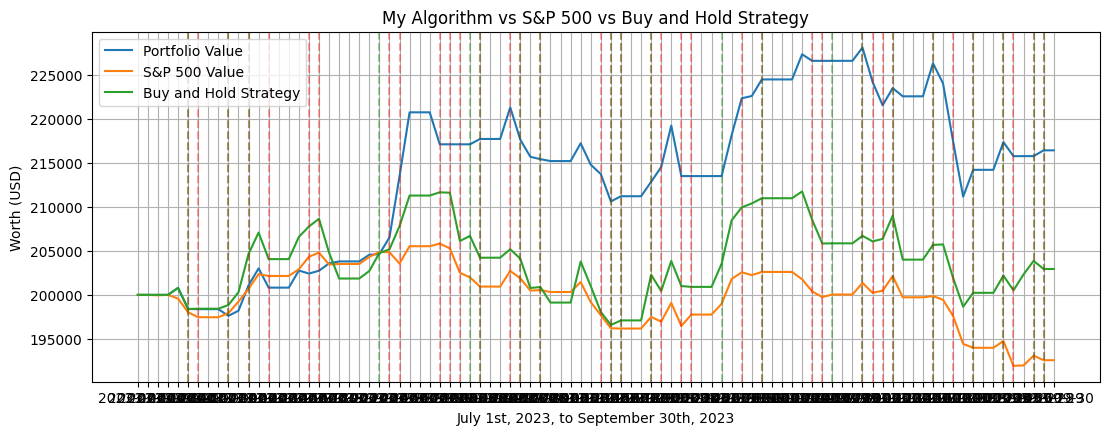

In [ ]:
'''After the algorithm finishes, this makes the graphs to show our results.'''
'''The red lines are for each day in which a stock in the portfolio was sold'''
'''The green lines are for each day a stock in the portfolio was bought
The brown lines are when a stock in the portfolio was both sold and bought that day'''
plt.figure(figsize=(13, 10))
plt.subplot(2, 1, 1)
plt.plot(dateList, portfolioValue, label="Portfolio Value")
plt.plot(dateList, SnpValue, label = "S&P 500 Value")
plt.plot(dateList, buyAndHold, label = "Buy and Hold Strategy")
plt.title("My Algorithm vs S&P 500 vs Buy and Hold Strategy")
plt.xlabel("July 1st, 2023, to September 30th, 2023")
plt.ylabel("Worth (USD)")
plt.grid(True)
plt.legend()

for i in range(len(dateList)):
     if daysSold[i] == 1:
        plt.axvline(x=i, color='r', linestyle='--', alpha = 0.35)
     if daysBought[i] == 1:
        plt.axvline(x=i, color='g', linestyle='--', alpha = 0.35)


## Plot Liquidity

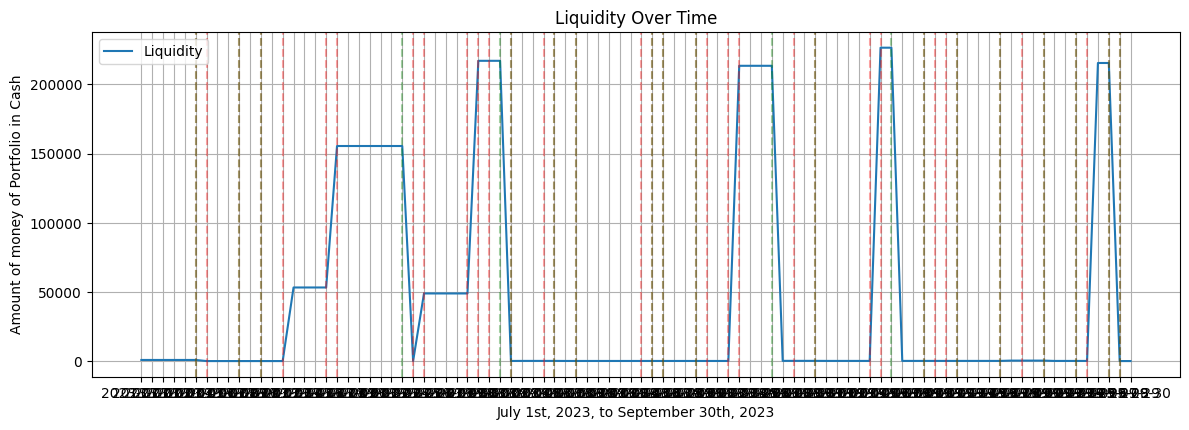

Summary: Stocks were traded on  42  days.
The final value of my portfolio was  216414.44228363037
The average value of my portfolio over the time period was  213663.87113571167
The final value of S&P 500 was  192584.23828125
Avg S&P 500 value over time was  199999.1114342731
The final value of Buy and Hold strategy was  202941.72998809814
The average value of the buy and hold portfolio was  203812.67566788715


In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
plt.plot(dateList, liquidity, label="Liquidity")
plt.title("Liquidity Over Time")
plt.xlabel("July 1st, 2023, to September 30th, 2023")
plt.ylabel("Amount of money of Portfolio in Cash")
plt.grid(True)
plt.legend()

counter = 0
avg = 0
snpAvg = 0
BAHavg = 0

for i in range(len(dateList)):
     snpAvg += SnpValue[i]
     avg += portfolioValue[i]
     BAHavg += buyAndHold[i]
     if daysSold[i] == 1:
        plt.axvline(x=i, color='r', linestyle='--', alpha = 0.35)
     if daysBought[i] == 1:
        plt.axvline(x=i, color='g', linestyle='--', alpha = 0.35)        
     if daysBought[i] == 1 or daysSold[i] == 1:
        counter += 1
         
plt.tight_layout()
plt.show()

print("Summary: Stocks were traded on ", counter, " days.")
print("The final value of my portfolio was " , portfolioValue[-1])
print("The average value of my portfolio over the time period was ", avg / len(portfolioValue))
print("The final value of S&P 500 was ", SnpValue[-1])
print("Avg S&P 500 value over time was ", snpAvg / len(SnpValue))
print("The final value of Buy and Hold strategy was ", buyAndHold[-1])
print("The average value of the buy and hold portfolio was ", BAHavg / len(buyAndHold) )
